### Rayleigh Plesset System

$$
\begin{align*}
\dot{\mathbf{u}} &= \mathbf{f}(\mathbf{u}, t) \\
\mathbf{u}(t_0) &= \mathbf{u}_0 \\
\mathbf{u} &= \begin{pmatrix} u_1 \\ u_2 \end{pmatrix} = \begin{pmatrix} R \\ \dot{R} \end{pmatrix} \\
\dot{\mathbf{u}} &= \begin{pmatrix} \dot{u}_1 \\ \dot{u}_2 \end{pmatrix} = \begin{pmatrix} \dot{R} \\ \ddot{R} \end{pmatrix} \\
\therefore \dot{\mathbf{u}} &= \begin{pmatrix} \dot{u}_1 \\ \dot{u}_2 \end{pmatrix} = \begin{pmatrix} u_2 \\ \ddot{R} \end{pmatrix} \\
\ddot{R} &= \frac{1}{\rho R} \left( P_v - P_{\infty}(t) + P_{g0} \left( \frac{R_0}{R} \right)^{3k} - \frac{2S}{R} - \frac{4\mu \dot{R}}{R} \right) - \frac{3 \dot{R}^2}{2 R} \\
\ddot{R} &= \frac{1}{\rho u_1} \left( P_v - P_{\infty}(t) + P_{g0} \left( \frac{R_0}{u_1} \right)^{3k} - \frac{2S}{u_1} - \frac{4\mu u_2}{u_1} \right) - \frac{3 u_2^2}{2 u_1}
\end{align*}
$$

### Building Numerical Methods

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Default Parameters
parameters = {
    'rho' : 998,      # surrounding water density in (kg/m^3)
    'mu' : 1e-3,      # water dynamic viscosity (Pa*s)
    'S' : 0.072,      # water surface tension (N/m)
    'p_v' : 2300,       # water vapor pressure (Pa) at 20 (degC). In bubble.
    'p_g0' : 1e5,       # initial gas pressure (Pa)
    'k' : 1.4,         # polytropic exponent
    'p_inf' : 1e5,      # ambient pressure (Pa)
    'R0' : 10e-6      # initial radius (m)
}

In [17]:
#rayleigh plesset system with constant pressure
def f_constant_p(u, t, rho=998, mu=1e-3, S=0.072, p_v=2300, p_g0=1.5e5, k=1.4, p_inf=1e5, R0=10e-6):
    'returns u dot'
    # u = [u1, u2] = [R, Rdot]

    u1 = u[0] # R
    u2 = u[1] # R_dot
    
    # R dot dot
    u2_dot = 1/(rho*u1) * (p_v - p_inf + p_g0*(R0/u1)**(3*k) - (2*S)/u1 - 4*mu*u2/u1) - ((3*u2**2)/(2*u1))

    u_dot = np.array([u2, u2_dot])

    return u_dot

#rayleigh plesset system with pressure burst
def f_burst(u, t, rho=998, mu=1e-3, S=0.072, p_v=2300, k=1.4,
           R0=10e-6, p_inf0=1e5, p_inf_high=3e6,
           t_burst=80e-6, p_g0_factor=1.05):
    """
    Bubble initially slightly overpressured,
    then ambient pressure jumps up at t_burst -> which causes the bubble to collapse (burst).
    """
    R, Rdot = u

    # Equilibrium gas pressure for given R0, p_inf0
    p_g_eq = p_inf0 + 2*S/R0 - p_v
    # Start slightly above equilibrium
    p_g0 = p_g_eq * p_g0_factor

    # Time-dependent ambient pressure
    if t < t_burst:
        p_inf = p_inf0         # Normal ambient (equilibrium stage)
    else:
        p_inf = p_inf_high     # Sudden rise -> collapse

    
    # Gas pressure inside bubble
    p_g = p_g0 * (R0 / R)**(3*k)

    # R̈ from Rayleigh–Plesset
    term1 = (p_v - p_inf + p_g - 2*S/R - 4*mu*Rdot/R)
    Rddot = (1/(rho*R)) * term1 - (3*Rdot**2)/(2*R)

    return np.array([Rdot, Rddot])

#rayleigh plesset system with time varying pressure
def f_driven(u, t, rho=998, mu=1e-3, S=0.072, p_v=2300, k=1.4,
             R0=10e-6, p0=1e5, P_a=0.0, f=0.0, p_g0_factor=1.05):
    """
    Computes Ṙ and R̈ for a single bubble in a liquid.
    p_inf(t) = p0 + P_a * sin(2π f t)
      - If P_a=0 → constant ambient pressure (Case 1)
      - If P_a>0 → time-varying ambient pressure (Case 2)
    """
    R, Rdot = u

    # Equilibrium gas pressure for given R0, p0
    p_g_eq = p0 + 2*S/R0 - p_v
    p_g0 = p_g_eq * p_g0_factor  # slightly overpressured

    # Time-dependent ambient pressure (driving force)
    p_inf = p0 + P_a * np.sin(2*np.pi*f*t)

    # Internal gas pressure
    p_g = p_g0 * (R0 / R)**(3*k)

    # Rayleigh–Plesset equation
    term1 = (p_v - p_inf + p_g - 2*S/R - 4*mu*Rdot/R)
    Rddot = (1/(rho*R)) * term1 - (3*Rdot**2)/(2*R)

    return np.array([Rdot, Rddot])

RK4 helper function

In [7]:
def rk4_step(u_k, t_k, dt, f_true):
    k1 = f_true(u_k, t_k)
    k2 = f_true(u_k + 1/2 * dt * k1, t_k + 1/2 * dt)
    k3 = f_true(u_k + 1/2 * dt * k2, t_k + 1/2 * dt)
    k4 = f_true(u_k + dt*k3, t_k + dt)

    u_k_plus1 = u_k + 1/6 *dt*(k1 + 2*k2 + 2*k3 + k4)

    return u_k_plus1

Runge Kutta 4th Order Method

In [8]:
def solve_rk4(u0, t0, tf, dt, f_true):
    """Solve IVP using RK4"""
    N = int((tf - t0) / dt)
    t = np.linspace(t0, tf, N+1)
    u = np.zeros((N+1, len(u0)))
    u[0] = u0

    for i in range(N):
        u[i+1] = rk4_step(u[i], t[i], dt, f_true)

    return t, u

Adam bashfort 4th order method with RK4 starter

In [9]:
def ab4_solver(u0, T, dt, f_true):
    num_steps = int(T/dt) + 1
    t = np.linspace(0, T, num_steps)

    u = np.zeros((num_steps, len(u0)))
    u[0] = u0

    #use rk4 to get the first two steps as it has the same truncation error as AB3
    u[1] = rk4_step(u[0], t[0], dt, f_true)
    u[2] = rk4_step(u[1], t[1], dt, f_true)
    u[3] = rk4_step(u[2], t[2], dt, f_true)

    for k in range(3, num_steps - 1):
        f_k = f_true(u[k], t[k])
        f_k_minus1 = f_true(u[k-1], t[k-1])
        f_k_minus2 = f_true(u[k-2], t[k-2])
        f_k_minus3 = f_true(u[k-3], t[k-3])

        u[k+1] = u[k] + dt/24 * (55*f_k - 59*f_k_minus1 + 37*f_k_minus2 - 9*f_k_minus3)

    return t, u


### Plotting constant ambient pressure solution

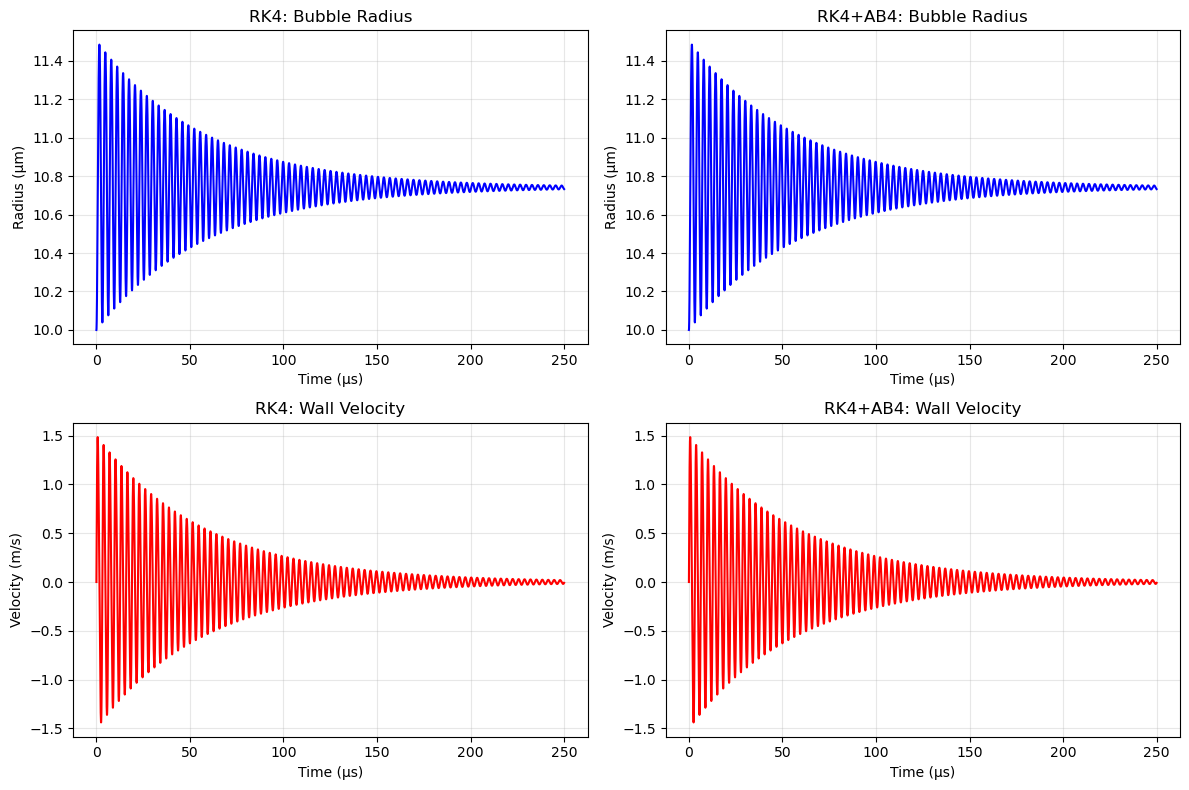


RK4 Final Radius: 10.7321 μm
RK4+AB4 Final Radius: 10.7321 μm
Difference: 0.000000 μm


In [ ]:
# Initial conditions and parameters
u0 = np.array([10e-6, 0])  # [R0, Rdot0]
t0 = 0
tf = 2.5e-4  # Final time
dt = 1e-9  # Time step

# Solve with both methods
t_rk4, u_rk4 = solve_rk4(u0, t0, tf, dt, f_constant_p)

# AB4 (which uses RK4 for its first 3 steps)
t_ab4, u_ab4 = ab4_solver(u0, tf, dt, f_constant_p)
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# RK4 - Radius
axes[0, 0].plot(t_rk4 * 1e6, u_rk4[:, 0] * 1e6, 'b-', linewidth=1.5)
axes[0, 0].set_xlabel('Time (μs)')
axes[0, 0].set_ylabel('Radius (μm)')
axes[0, 0].set_title('RK4: Bubble Radius')
axes[0, 0].grid(True, alpha=0.3)

# RK4 - Velocity
axes[1, 0].plot(t_rk4 * 1e6, u_rk4[:, 1], 'r-', linewidth=1.5)
axes[1, 0].set_xlabel('Time (μs)')
axes[1, 0].set_ylabel('Velocity (m/s)')
axes[1, 0].set_title('RK4: Wall Velocity')
axes[1, 0].grid(True, alpha=0.3)

# RK4+AB4 - Radius
axes[0, 1].plot(t_ab4 * 1e6, u_ab4[:, 0] * 1e6, 'b-', linewidth=1.5)
axes[0, 1].set_xlabel('Time (μs)')
axes[0, 1].set_ylabel('Radius (μm)')
axes[0, 1].set_title('RK4+AB4: Bubble Radius')
axes[0, 1].grid(True, alpha=0.3)

# RK4+AB4 - Velocity
axes[1, 1].plot(t_ab4 * 1e6, u_ab4[:, 1], 'r-', linewidth=1.5)
axes[1, 1].set_xlabel('Time (μs)')
axes[1, 1].set_ylabel('Velocity (m/s)')
axes[1, 1].set_title('RK4+AB4: Wall Velocity')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rayleigh_plesset_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRK4 Final Radius: {u_rk4[-1, 0]*1e6:.4f} μm")
print(f"RK4+AB4 Final Radius: {u_ab4[-1, 0]*1e6:.4f} μm")
print(f"Difference: {abs(u_rk4[-1, 0] - u_ab4[-1, 0])*1e6:.6f} μm")

### Plotting with varying constant ambient pressures solution

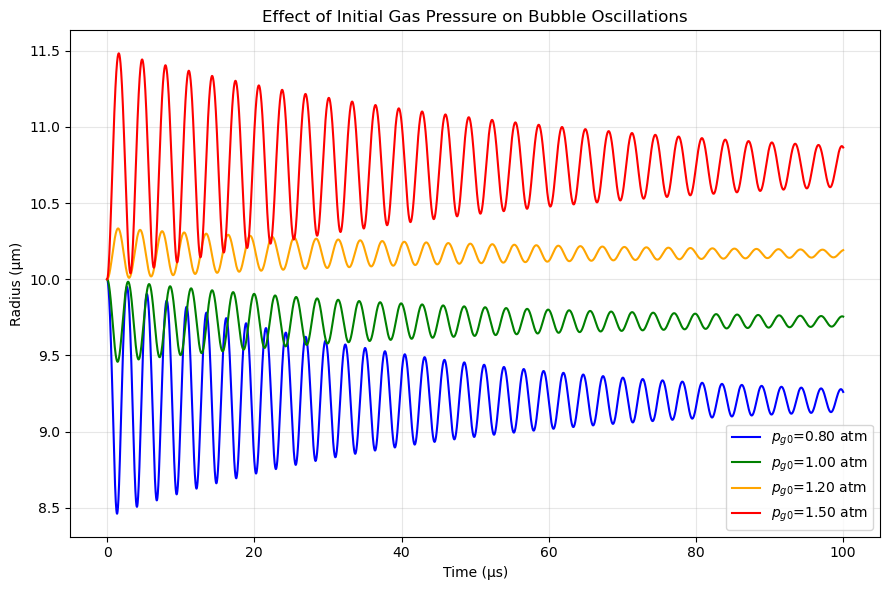

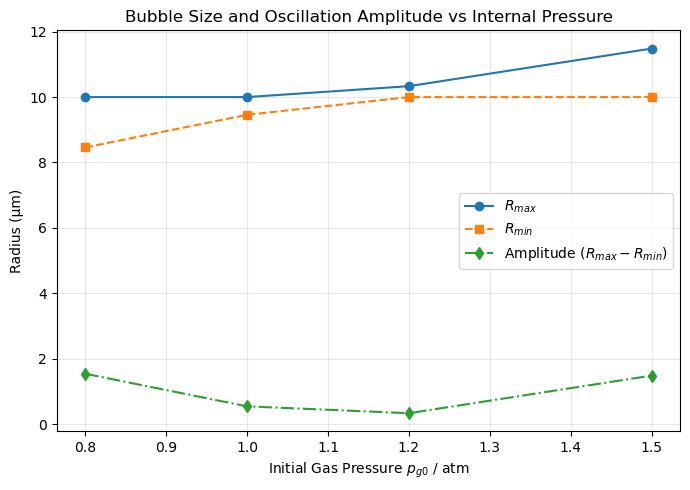

p_g0=0.80 atm → R_max=10.000 µm, R_min=8.460 µm, ΔR=1.540 µm
p_g0=1.00 atm → R_max=10.000 µm, R_min=9.458 µm, ΔR=0.542 µm
p_g0=1.20 atm → R_max=10.334 µm, R_min=10.000 µm, ΔR=0.334 µm
p_g0=1.50 atm → R_max=11.483 µm, R_min=10.000 µm, ΔR=1.483 µm


In [31]:
# Varies initial gas pressures to see how the oscillation behavior changes

p_g0_values = [0.8e5, 1.0e5, 1.2e5, 1.5e5]  # list of varying initial gas pressures at R0 [Pa]
colors = ['b', 'g', 'orange', 'r'] # colours for each plot
results = [] #initialize results list to hold (p_g0, R_max[µm], R_min[µm]) for summary plots

plt.figure(figsize=(9,6))
#Below was produced with the help of generative ai
for pg, c in zip(p_g0_values, colors):
    # For each p_g0, create a tiny wrapper so the solver sees that specific internal pressure.
    # Everything else (ρ, μ, S, p_v, k, p_inf, R0) stays the same.
    def f_temp(u, t):
        return f_constant_p(u, t, p_g0=pg)

    # Integrate using existing RK4 solver with the same time grid.
    t, u = solve_rk4(u0, t0, tf, dt, f_temp)

    # Extract just the radius time history; u = [R, Rdot]
    R = u[:,0]

    # Plot radius vs time for this p_g0 (units: time in µs, radius in µm)
    plt.plot(t*1e6, R*1e6, color=c, label=f'$p_{{g0}}$={pg/1e5:.2f} atm')

    # Keep track of max/min radius so we can compare amplitudes across p_g0
    results.append((pg, R.max()*1e6, R.min()*1e6))

# Make the figure readable
plt.xlabel("Time (µs)")
plt.ylabel("Radius (µm)")
plt.title("Effect of Initial Gas Pressure on Bubble Oscillations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Convert the logged results into arrays we can plot easily

p_vals = np.array([r[0] for r in results]) / 1e5  # express p_g0 in atmospheres for the x-axis
R_max = np.array([r[1] for r in results])         # µm
R_min = np.array([r[2] for r in results])         # µm
Amplitude = R_max - R_min                          # µm, simple peak-to-trough measure

plt.figure(figsize=(7,5))
plt.plot(p_vals, R_max, 'o-', label='$R_{max}$')                             # expansion peak
plt.plot(p_vals, R_min, 's--', label='$R_{min}$')                            # collapse trough
plt.plot(p_vals, Amplitude, 'd-.', label='Amplitude ($R_{max}-R_{min}$)')    # oscillation size
plt.xlabel('Initial Gas Pressure $p_{g0}$ / atm')
plt.ylabel('Radius (µm)')
plt.title('Bubble Size and Oscillation Amplitude vs Internal Pressure')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quick table for report

for pg, Rmax, Rmin in results:
    print(
        f"p_g0={pg/1e5:.2f} atm → "
        f"R_max={Rmax:.3f} µm, "
        f"R_min={Rmin:.3f} µm, "
        f"ΔR={Rmax-Rmin:.3f} µm"
    )

Since there is no difference in final radius between RK4 and AB4 methods for constant ambient pressure, only RK4 methods are further analysed.

### Errro Convergence of RK4

In [19]:
def rk4_normalized_error(u0, t0, tf, dt, dt_baseline, f_true):
    """
    Calculates the norm error of the final state vector 
    for a single dt, compared to a baseline solution which is an extremely small dt.
    """
    # Calculate the solution for the given dt
    _, u_solution = solve_rk4(u0, t0, tf, dt, f_true)
    u_final_test = u_solution[-1]  # Get the final state vector [R, R_dot]

    # The baseline solution uses an extremely small dt which is ideally the most accurate
    _, u_baseline = solve_rk4(u0, t0, tf, dt_baseline, f_true)
    u_final_baseline = u_baseline[-1] # Get the final "true" state vector

    # Calculate the norm of the error between chosen dt and baseline
    error_norm = np.linalg.norm(u_final_test - u_final_baseline)

    # Calculate the norm of the baseline state vector to normalize the error
    baseline_norm = np.linalg.norm(u_final_baseline)
    
    # Avoid division by zero
    if baseline_norm == 0:
        return 0.0
        
    # Return the relative error
    err = error_norm / baseline_norm
    
    return err

Plotting error convergence of RK4 method

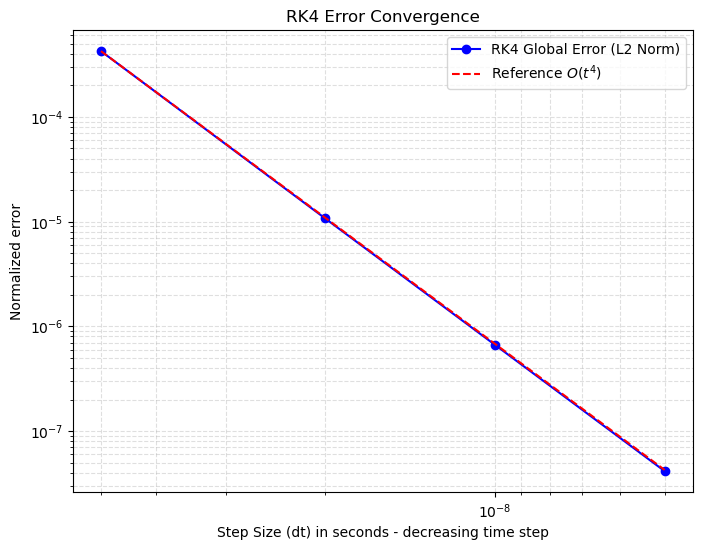

In [30]:
u0 = np.array([10e-6, 0]) # Initial conditions
t0 = 0
tf = 1e-4  # final time
dt_baseline = 1e-9  # 1 nanosec time step which represents the true solution
dt_to_test = np.array([5e-8, 2e-8, 1e-8, 5e-9])
error_values = []

for dt in dt_to_test:
    error = rk4_normalized_error(u0, t0, tf, dt, dt_baseline, f_constant_p)
    error_values.append(error)

plt.figure(figsize=(8, 6))
plt.loglog(dt_to_test, error_values, 'bo-', label='RK4 Global Error (L2 Norm)')

# Plot a reference O(dt^4) line
# C = E/h^4, so C = E_0 / h_0^4
C = error_values[0] / (dt_to_test[0]**4)
plt.loglog(dt_to_test, C * (dt_to_test**4), 'r--', label='Reference $O(t^4)$')

plt.xlabel('Step Size (dt) in seconds - decreasing time step')
plt.ylabel('Normalized error')
plt.title('RK4 Error Convergence')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.gca().invert_xaxis()  # Flips axis to show time step decreasing from left to right
plt.show()

### Plotting solution for a bubble bursting

C:\Users\bahbi\AppData\Local\Temp\ipykernel_1972\4119431434.py:39: RuntimeWarning: invalid value encountered in scalar power
  p_g = p_g0 * (R0 / R)**(3*k)


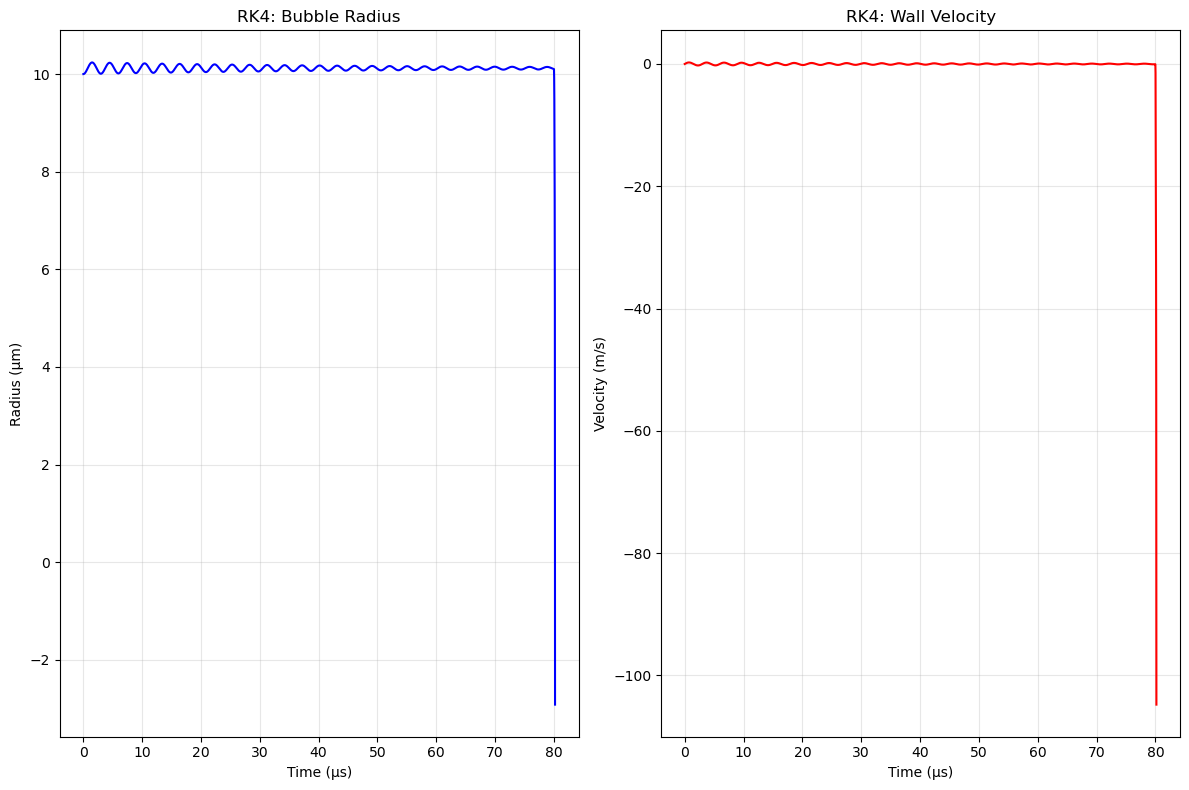


RK4 Final Radius: nan μm


In [18]:
# Initial conditions and parameters
u0 = np.array([10e-6, 0])  # [R0, Rdot0]
t0 = 0
tf = 5e-4  # final time
dt = 3e-8  # time step

# Solve with both methods
t_rk4, u_rk4 = solve_rk4(u0, t0, tf, dt, f_burst)

# AB4 (which uses RK4 for its first 3 steps)
t_ab4, u_ab4 = ab4_solver(u0, tf, dt, f_burst)
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# RK4 - Radius
axes[0].plot(t_rk4 * 1e6, u_rk4[:, 0] * 1e6, 'b-', linewidth=1.5)
axes[0].set_xlabel('Time (μs)')
axes[0].set_ylabel('Radius (μm)')
axes[0].set_title('RK4: Bubble Radius')
axes[0].grid(True, alpha=0.3)

# RK4 - Velocity
axes[1].plot(t_rk4 * 1e6, u_rk4[:, 1], 'r-', linewidth=1.5)
axes[1].set_xlabel('Time (μs)')
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_title('RK4: Wall Velocity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rayleigh_plesset_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRK4 Final Radius: {u_rk4[-1, 0]*1e6:.4f} μm")

### Bubble Dynamics under transient ambient pressure (driven oscillation)

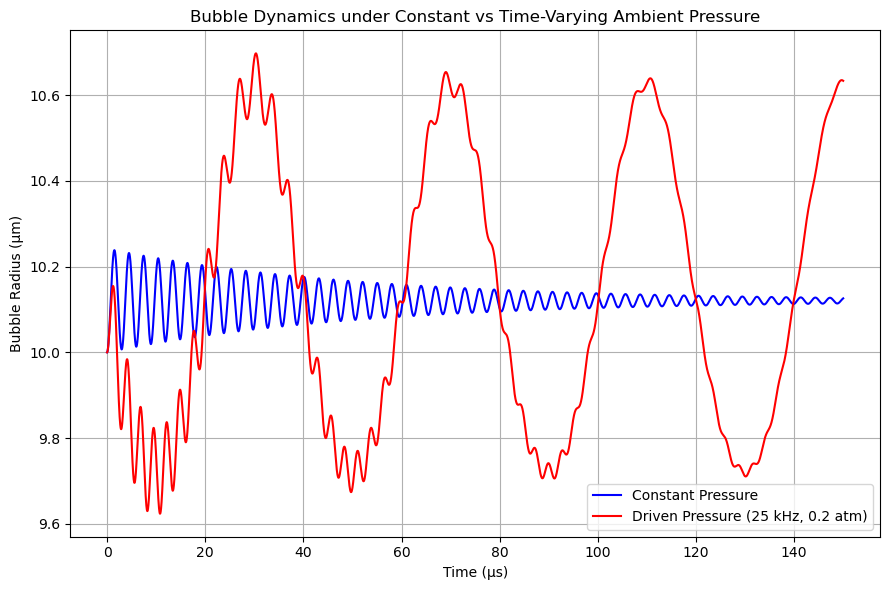

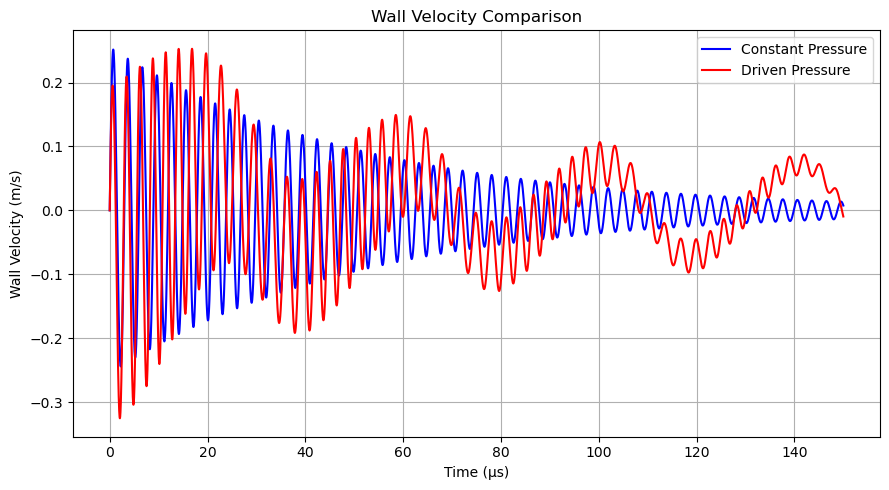

Driven Case — Minimum radius: 9.624 µm at 10.801 µs
Driven Case — Max velocity: 0.33 m/s


In [24]:
# simulating bubble dynamics under constant and time-varying ambient pressure
R0 = 10e-6 # Initial bubble radius
u0 = np.array([R0, 0.0]) # Initial conditions
t0, tf, dt = 0, 150e-6, 2e-8 

# Case 1 - constant ambient pressure
t_const, u_const = solve_rk4(
    u0, t0, tf, dt,
    lambda u, t: f_driven(u, t, P_a=0.0, f=0.0)
)

# Case 2 - Time-varying (sinusoidal) ambient pressure
# acoustic driving: amplitude = 0.2 atm, frequency = 25 kHz
t_var, u_var = solve_rk4(
    u0, t0, tf, dt,
    lambda u, t: f_driven(u, t, P_a=2e4, f=25e3)
)

# Extract results to plot
R_const, Rdot_const = u_const[:,0], u_const[:,1]
R_var, Rdot_var = u_var[:,0], u_var[:,1]

# Plot results: Radius over time
plt.figure(figsize=(9,6))
plt.plot(t_const*1e6, R_const*1e6, label="Constant Pressure", color='b')
plt.plot(t_var*1e6, R_var*1e6, label="Driven Pressure (25 kHz, 0.2 atm)", color='r')
plt.xlabel("Time (µs)")
plt.ylabel("Bubble Radius (µm)")
plt.title("Bubble Dynamics under Constant vs Time-Varying Ambient Pressure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot velocity comparison
plt.figure(figsize=(9,5))
plt.plot(t_const*1e6, Rdot_const, label="Constant Pressure", color='b')
plt.plot(t_var*1e6, Rdot_var, label="Driven Pressure", color='r')
plt.xlabel("Time (µs)")
plt.ylabel("Wall Velocity (m/s)")
plt.title("Wall Velocity Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary metrics
idx_min = np.argmin(R_var)
print(f"Driven Case — Minimum radius: {R_var[idx_min]*1e6:.3f} µm at {t_var[idx_min]*1e6:.3f} µs")
print(f"Driven Case — Max velocity: {np.max(np.abs(Rdot_var)):.2f} m/s")